# Demonstration of surrogate model capabilities

This is a simple jupyter notebook to demonstrate the autogluon surrogate model capability.

Author: Soheyl Massoudi <smassoudi@ethz.ch>

# Step 1: Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Step 2: Load and Convert Parquet Dataset

In [26]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")

Dataset saved to ./data/airfoil_data.csv


In [27]:
dataset.column_names

['initial',
 'optimized',
 'mach',
 'reynolds',
 'cl_target',
 'area_target',
 'alpha',
 'area_initial',
 'cd_val',
 'cl_val',
 'cl_con',
 'area_con']

In [28]:
type(dataset['alpha'])

list

In [29]:
dataset['optimized'][1][0]

[1.0000194365938981,
 0.9897566593945221,
 0.9794544269870155,
 0.9691149136515305,
 0.9587402901643374,
 0.9483327419340516,
 0.9378945048481954,
 0.9274277968572291,
 0.9169348081262216,
 0.9064178020370062,
 0.8958790284346422,
 0.8853207187330372,
 0.8747448930482233,
 0.8641523083004454,
 0.8535437159737151,
 0.8429198967977035,
 0.8322817488654743,
 0.8216301200165563,
 0.8109658171290856,
 0.8002897285258235,
 0.7896027290487984,
 0.7789056461533759,
 0.7681993584263407,
 0.7574847603720507,
 0.7467626918304485,
 0.7360340279427758,
 0.7253037272659675,
 0.7145732743519277,
 0.7038473442473052,
 0.693126502752131,
 0.6824101435303259,
 0.6716976408464019,
 0.6609883248618159,
 0.6502815861483213,
 0.639576822934429,
 0.6288733614389102,
 0.6181705789840656,
 0.6074655520675161,
 0.5967516390819786,
 0.5860288162351749,
 0.5752975145222803,
 0.5645582221285628,
 0.5538114139478776,
 0.5430575344024076,
 0.5322970595788166,
 0.5215304770239737,
 0.5107583657552618,
 0.499988999525

# Step 3: Flatten columns and get X and Y datasets

In [52]:
def recursive_flatten(val):
    """
    Recursively flatten a nested list/tuple into a single list of values.
    E.g. [[x0, x1], [y0, y1]] -> [x0, x1, y0, y1].
    """
    if not isinstance(val, (list, tuple)):
        return [val]
    else:
        result = []
        for item in val:
            result.extend(recursive_flatten(item))
        return result

def flatten_list_columns_nested(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each column in `df` where the first row is a list,
    recursively flatten that column and expand into multiple new numeric columns.
    """
    import pandas as pd
    
    new_cols_list = []
    drop_cols = []
    
    for col in df.columns:
        first_value = df[col].iloc[0]
        # Check if the first row is a list/tuple --> likely all rows are lists
        if isinstance(first_value, (list, tuple)):
            # Flatten each row, store in a temporary list
            flattened_rows = [recursive_flatten(val) for val in df[col]]
            # Ensure consistent length across rows
            lengths = [len(row) for row in flattened_rows]
            unique_lengths = set(lengths)
            if len(unique_lengths) > 1:
                raise ValueError(
                    f"Column '{col}' has rows of varying lengths {unique_lengths}. "
                    "Cannot flatten consistently without special handling."
                )
            # Create new DataFrame with columns [col_0, col_1, ..., col_(n-1)]
            n = lengths[0]
            new_col_names = [f"{col}_{i}" for i in range(n)]
            expanded_df = pd.DataFrame(flattened_rows, columns=new_col_names)
            new_cols_list.append(expanded_df)
            drop_cols.append(col)
    
    if new_cols_list:
        # Drop original list-columns and concatenate new expanded columns
        df = pd.concat(
            [df.drop(columns=drop_cols).reset_index(drop=True)] + new_cols_list,
            axis=1
        )
    return df

# Flatten the nested list columns
df = flatten_list_columns_nested(df)


In [31]:
# The flattened columns for "optimized" will now appear as "optimized_0", "optimized_1", etc.
# Let's find all columns that start with "optimized_"
opt_cols = [col for col in df.columns if col.startswith("optimized_")]

# Or you can do them all if you know the exact count/structure

# Additional numeric columns we want
other_input_cols = ["mach", "reynolds", "alpha"]

# Combine them
feature_cols = opt_cols + other_input_cols

target_col = "cl_val"

# Create X and y
X = df[feature_cols].values
y = df[target_col].values


# Step 4: Split Inputs and Targets

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Suppose X is shape [n_samples, n_features], y is shape [n_samples]
# (Replace with your actual arrays from the flattened dataset.)

# 1) Split off test data (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Split the remaining into train and validation (25% of X_temp = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Optionally scale target as well
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


Train size: (448, 387), Val size: (150, 387), Test size: (150, 387)


# Step 5: Define a Pytorch Dataset and Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train_scaled, y_train_scaled)
val_dataset   = TabularDataset(X_val_scaled,   y_val_scaled)
test_dataset  = TabularDataset(X_test_scaled,  y_test_scaled)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


class SimpleRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_scaled.shape[1]  # Number of features
hidden_dim = 64
model = SimpleRegressor(input_dim, hidden_dim, output_dim=1)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model.to(device)

num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []

best_model_weights = None
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # --- Training Loop ---
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(X_batch).squeeze(-1)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch).squeeze(-1)
            loss = criterion(predictions, y_batch)
            running_val_loss += loss.item() * X_batch.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        epochs_no_improve = 0
        # Store best weights
        best_model_weights = model.state_dict()
    else:
        epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early stopping condition
    if epochs_no_improve >= patience:
        print(f"Validation loss has not improved for {patience} epochs. Stopping early.")
        break

# --- After training, restore the best weights ---
print(f"Best validation loss = {best_val_loss:.4f} at epoch {best_epoch+1}.")
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)



Epoch 1/100 - Train Loss: 0.7395, Val Loss: 0.6524
Epoch 2/100 - Train Loss: 0.5245, Val Loss: 0.5493
Epoch 3/100 - Train Loss: 0.3802, Val Loss: 0.4495
Epoch 4/100 - Train Loss: 0.3248, Val Loss: 0.4305
Epoch 5/100 - Train Loss: 0.2520, Val Loss: 0.3603
Epoch 6/100 - Train Loss: 0.2050, Val Loss: 0.2966
Epoch 7/100 - Train Loss: 0.1689, Val Loss: 0.2886
Epoch 8/100 - Train Loss: 0.1524, Val Loss: 0.2350
Epoch 9/100 - Train Loss: 0.1245, Val Loss: 0.2226
Epoch 10/100 - Train Loss: 0.1036, Val Loss: 0.2187
Epoch 11/100 - Train Loss: 0.1011, Val Loss: 0.1825
Epoch 12/100 - Train Loss: 0.0900, Val Loss: 0.1778
Epoch 13/100 - Train Loss: 0.0818, Val Loss: 0.1488
Epoch 14/100 - Train Loss: 0.0787, Val Loss: 0.1366
Epoch 15/100 - Train Loss: 0.0795, Val Loss: 0.1323
Epoch 16/100 - Train Loss: 0.0704, Val Loss: 0.1219
Epoch 17/100 - Train Loss: 0.0646, Val Loss: 0.1189
Epoch 18/100 - Train Loss: 0.0453, Val Loss: 0.1147
Epoch 19/100 - Train Loss: 0.0436, Val Loss: 0.1137
Epoch 20/100 - Train 

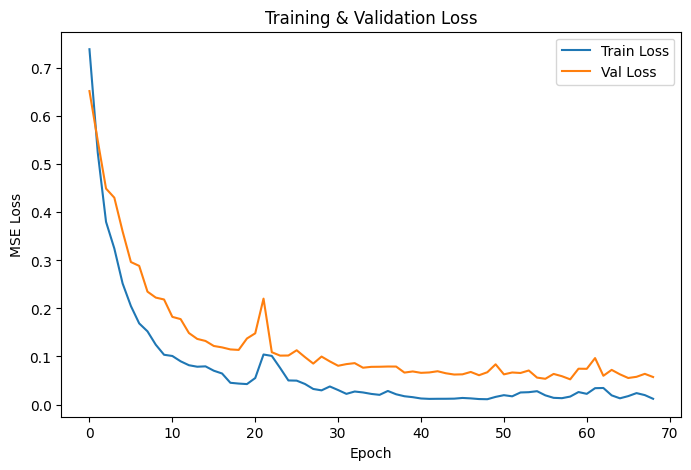

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


# Step 6: Predictions and Inverse Transform

In [35]:
model.eval()
test_preds_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch).squeeze(-1)

        test_preds_scaled.append(preds.cpu().numpy())
        test_targets_scaled.append(y_batch.cpu().numpy())

test_preds_scaled = np.concatenate(test_preds_scaled)
test_targets_scaled = np.concatenate(test_targets_scaled)

# Inverse transform if you scaled the target
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
test_targets = scaler_y.inverse_transform(test_targets_scaled.reshape(-1, 1)).flatten()

# Calculate the final test MSE or RMSE
mse_test = np.mean((test_preds - test_targets)**2)
rmse_test = np.sqrt(mse_test)
print(f"Test MSE:  {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Display a small sample of true vs predicted
print("\nSample of predictions vs true values:")
for i in range(5):
    print(f"Predicted: {test_preds[i]:.4f},  True: {test_targets[i]:.4f},  Diff: {test_preds[i] - test_targets[i]:.4f}")


Test MSE:  0.0022
Test RMSE: 0.0474

Sample of predictions vs true values:
Predicted: 0.7814,  True: 0.7862,  Diff: -0.0049
Predicted: 0.9527,  True: 0.9167,  Diff: 0.0359
Predicted: 0.7288,  True: 0.7405,  Diff: -0.0116
Predicted: 0.8102,  True: 0.8399,  Diff: -0.0297
Predicted: 0.8373,  True: 0.8537,  Diff: -0.0164


In [ ]:
# Step 1: Setup

In [1]:
from datasets import load_dataset
import pandas as pd
import os

# Specify the directory and file path
csv_directory = "./data"
csv_file_name = "airfoil_data.csv"
csv_path = os.path.join(csv_directory, csv_file_name)
absolute_csv_path = os.path.abspath(csv_path)

# Create the directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Load dataset from Hugging Face
dataset = load_dataset("IDEALLab/airfoil_2d_v0", split="train")

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)

# Save to CSV
df.to_csv(absolute_csv_path, index=False)

print(f"Dataset saved to {csv_path}")



/opt/anaconda3/envs/engibench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset saved to ./data/airfoil_data.csv


## Step 

## Step 2: Load surrogate model from engiopt

In [ ]:
import sys
import os

# Add the path to the directory containing your AutoGluon script
sys.path.append(os.path.abspath("../EngiOpt/engiopt"))

# Now you can import and use the script as if it's in the same directory
#from autogluon_multimodal import main


!python ../EngiOpt/engiopt/ann_tabular_regression.py \
    --data_path "../Engibench/data/airfoil_data.csv" \
    --input_cols '["optimized", "mach", "reynolds", "alpha"]' \
    --target_col "cl_val" \
    --no-auto_detect_flatten \
    --hidden_layers 2 \
    --hidden_size 64 \
    --activation relu \
    --optimizer adam \
    --learning_rate 1e-3 \
    --n_epochs 50 \
    --batch_size 32 \
    --patience 10 \
    --scale_target \
    --no-track \
    --wandb_project "engiopt_ann_tabular_regression" \
    --seed 42 \
    --save_model \






Traceback (most recent call last):
  File "/Users/smassoudi/Library/CloudStorage/OneDrive-ETHZurich/Code_Collaborative/EngiBench/../EngiOpt/engiopt/ann_tabular_regression.py", line 116, in __post_init__
    parsed_value = ast.literal_eval(value[0])
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/engibench/lib/python3.11/ast.py", line 110, in literal_eval
    return _convert(node_or_string)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/engibench/lib/python3.11/ast.py", line 109, in _convert
    return _convert_signed_num(node)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/engibench/lib/python3.11/ast.py", line 83, in _convert_signed_num
    return _convert_num(node)
           ^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/engibench/lib/python3.11/ast.py", line 74, in _convert_num
    _raise_malformed_node(node)
  File "/opt/anaconda3/envs/engibench/lib/python3.11/ast.py", line 71, in _raise_malformed_node
    raise ValueErr

In [28]:
problem = airfoil2d_v0.build()
problem.reset(99)

u22-gcc-ompi-stable: Pulling from mdolab/public
Digest: sha256:8a2349b7a2587b3317ad09b6a8096f615cc4c4283f43879e897e3ad53e830cd9
Status: Image is up to date for mdolab/public:u22-gcc-ompi-stable
docker.io/mdolab/public:u22-gcc-ompi-stable
Creating study directory: /Users/ffelte/Documents/EngiBench/engibench_studies/problems/airfoil2d/study_99
Copying files from /Users/ffelte/Documents/EngiBench/engibench/problems/airfoil2d/templates to /Users/ffelte/Documents/EngiBench/engibench_studies/problems/airfoil2d/study_99
Creating study directory: /Users/ffelte/Documents/EngiBench/engibench_studies/problems/airfoil2d
Copying files from /Users/ffelte/Documents/EngiBench/engibench/problems/airfoil2d/scripts to /Users/ffelte/Documents/EngiBench/engibench_studies/problems/airfoil2d



What's Next?
  View a summary of image vulnerabilities and recommendations → docker scout quickview mdolab/public:u22-gcc-ompi-stable


## Step 2: Inspect the Problem

### 2.1: Representation, Objectives, Boundary Conditions
The output just below means our airfoil is parameterized by 192 (`x, y`) positions in `[0, 1]`.

In [22]:
problem.design_space

Box(0.0, 1.0, (2, 192), float32)

In [23]:
problem.possible_objectives

frozenset({('cd', 'minimize'), ('cl', 'maximize')})

In [24]:
problem.boundary_conditions

frozenset({('marchDist', 100.0), ('s0', 3e-06)})

### 2.2 Data
We can directly access [the dataset linked to the problem](https://huggingface.co/datasets/IDEALLab/airfoil_2d_v0) doing the following:

In [25]:
problem.dataset

DatasetDict({
    train: Dataset({
        features: ['initial', 'optimized', 'mach', 'reynolds', 'cl_target', 'area_target', 'alpha', 'area_initial', 'cd_val', 'cl_val', 'cl_con', 'area_con'],
        num_rows: 748
    })
    val: Dataset({
        features: ['initial', 'optimized', 'mach', 'reynolds', 'cl_target', 'area_target', 'alpha', 'area_initial', 'cd_val', 'cl_val', 'cl_con', 'area_con'],
        num_rows: 140
    })
    test: Dataset({
        features: ['initial', 'optimized', 'mach', 'reynolds', 'cl_target', 'area_target', 'alpha', 'area_initial', 'cd_val', 'cl_val', 'cl_con', 'area_con'],
        num_rows: 47
    })
})

## Step 3: Creating a Design and Launching the Simulator
While you usually would generate a design based on a generative or surrogate mode, we here show how to play with a rather random one.

In [ ]:
my_design = problem.random_design()
my_design

You can also render designs to see what they look like.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

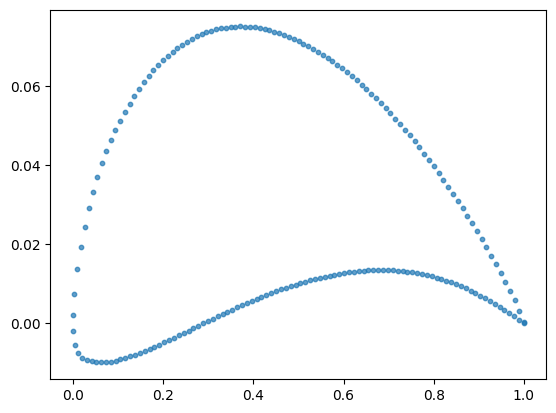

In [27]:
problem.render(my_design)

Finally, you can:
- Simulate a design to get its objective values with `objs = problem.simulate(my_design)`
- Optimize a given design with `optimal_design, objs = problem.optimize(my_design)`

Note that this is not trivially doable here since the simulation requires launching a container 😅.